In [1]:
import os
from IPython.display import Image
from tensorflow import keras
from keras import layers

import tensorflow as tf
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import imageio
from utils import *

In [2]:
#!pip install "gymnasium[classic_control]"

In [3]:
env = gym.make("Pendulum-v1" , render_mode="rgb_array", g=9.81)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}, represented by the torque".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}, represented by the x, y, and angular velocity".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))


Size of State Space ->  3, represented by the torque
Size of Action Space ->  1, represented by the x, y, and angular velocity
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


In [4]:
frames = []
state = env.reset()
for _ in range(200):  # Number of steps to simulate
    # Render the environment and collect the frame
    frame = env.render()
    frames.append(frame)

    # Take random actions
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)
imageio.mimsave('initial_state.gif', frames, fps=30,loop=0) 

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


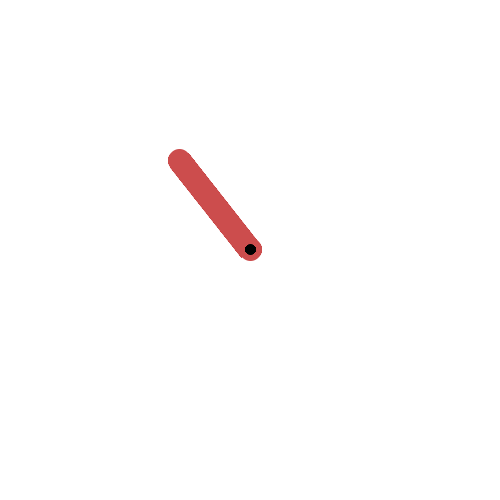

In [5]:
Image(filename="initial_state.gif")

# Let's build the noise injection and the actor and critic models!

In [6]:
std_dev = 0.2 #standard deviation for the stochastic noise added to actions
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor(num_states)
critic_model = get_critic(num_states,num_actions)

#Slow updating models to improve stability
target_actor = get_actor(num_states)
target_critic = get_critic(num_states,num_actions)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

total_episodes = 90
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = RLTrainer(actor_model,critic_model,target_actor,target_critic,
                   num_states,num_actions,
                   gamma,tau, 
                   buffer_capacity = 50000, 
                   batch_size = 64,
                   critic_lr = critic_lr,
                   actor_lr = actor_lr,
                  )

In [7]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

In [8]:
for ep in range(total_episodes):
    prev_state, _ = env.reset()
    episodic_reward = 0

    while True:
        tf_prev_state = tf.expand_dims(
            tf.convert_to_tensor(prev_state), 0
        )

        action = policy(tf_prev_state, ou_noise,actor_model)
        # Receive state and reward from environment.
        state, reward, done, truncated, _ = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()

        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        # End this episode when `done` or `truncated` is True
        if done or truncated:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

Episode * 0 * Avg Reward is ==> -1813.3812259939853
Episode * 1 * Avg Reward is ==> -1345.0364503451333
Episode * 2 * Avg Reward is ==> -1314.5136327820992
Episode * 3 * Avg Reward is ==> -1381.1994526263115
Episode * 4 * Avg Reward is ==> -1420.8993965186257
Episode * 5 * Avg Reward is ==> -1401.245407013673
Episode * 6 * Avg Reward is ==> -1395.6172547597193
Episode * 7 * Avg Reward is ==> -1383.1506427517584
Episode * 8 * Avg Reward is ==> -1399.7858695299171
Episode * 9 * Avg Reward is ==> -1354.949715270635
Episode * 10 * Avg Reward is ==> -1326.007823848515
Episode * 11 * Avg Reward is ==> -1259.8442237181923
Episode * 12 * Avg Reward is ==> -1163.1271352047506
Episode * 13 * Avg Reward is ==> -1108.1865351557483
Episode * 14 * Avg Reward is ==> -1065.0256787463395
Episode * 15 * Avg Reward is ==> -998.6182656068513
Episode * 16 * Avg Reward is ==> -964.0855440350649
Episode * 17 * Avg Reward is ==> -917.4011114792288
Episode * 18 * Avg Reward is ==> -885.4330781838838
Episode * 

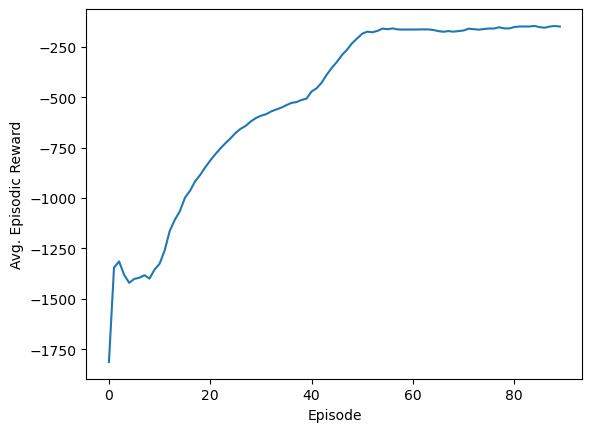

In [9]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")
plt.show()

In [10]:
frames = []
state, _ = env.reset()
state = np.expand_dims(state, axis=0)
for _ in range(400):  # Number of steps to simulate
    # Render the environment and collect the frame
    frame = env.render()
    frames.append(frame)
    
    action = actor_model.predict(state, verbose=0)  # Replace with your model's predict function
    action = action[0] 

    next_state, reward, done, truncated, info = env.step(action)
    state = np.expand_dims(next_state, axis=0)  # Update state

imageio.mimsave('trained_state.gif', frames, fps=30,loop=0) 

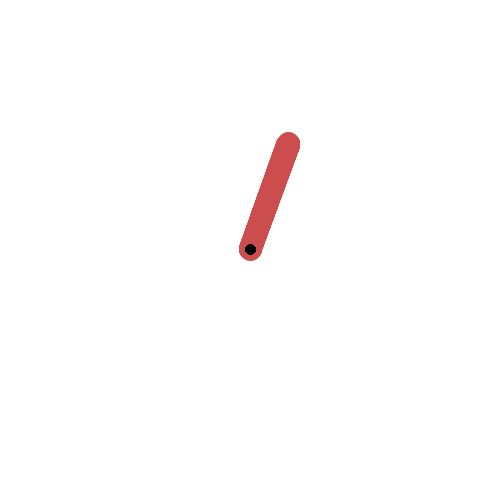

In [11]:
Image(filename="trained_state.gif")